# Risk Scorecard Development:
> <font size =  "4"> This notebook describes the procedure to develop transaction risk score and risk scorecard.</font>
## Risk Score:
> <font size =  "4"> A risk score is a numerical score that is derived from the statistical analysis and represents transactions riskiness. Higher risk score corresponds to high fraud probability. </font>

> <font size =  "4"> This concept of scorecard development is popular in finance industry. Various types of scores like risk scores, credit scores, credit rating are being developed in financial domain to understand credit risk, default risk, product pricing etc. Risk scores are usually developed using big data analytics and efficient machine learning algorithms, including, but not limited to, logistic regression, ensemble, and gradient boosting decision trees. </font>

## Developing the Risk Scores from predicted probabilities of developed model:
> <font size =  "4"> Once the machine learning model is assessed and finalized to be implemented in production, transaction risk scores and scorecard should be developed. These risk scores are further used to decide the score threshold for transaction acceptance decisioning in real time. </font>

> <font size =  "4"> <font color='yellow'> Defining threshold for transaction acceptance decision, based on the developed models prediction probabilities will be challenging as transactions predicted probabilities will be tightly placed between small scale. So, it necessitates the scaling methodology which can scale the predicted probabilities to a large range of scores. </font> </font>

> <font size =  "4"> For developing risk scores, logistic regression is used as it assumes linearity between the dependent and the response variables. Lets first compute the risk score and then develop the risk scorecard. </font>

## 1. Risk Score Computation
#### Explanatory example:
> <font size =  "4"> Following simple example describes the steps along with the code for developing the risk score. This example is just for reference and you do not need to input your data in this code. </font>

<font size =  "4"> Following is a risk score development process flow: </font>

<font size =  "4">
    
1. Compute log of odds (log(good/bad)) of each transaction. 
2. Train a logistic regression model on log of odds, fraud labels and get intercept and slope of line which separates log of odds and log of fraud labels. 
3. Develop risk scores by using log(odds), slope and intercept of logistic regression and by tuning PDO, score corresponding to 1% bad rate.
    </font>

### <font color='yellow'> Definitions: </font>
#### log of odds:
> <font size =  "4"> Ratio of transactions chances of being good to bad is odds and its log is log of odds. These good and bad probabilities are developed models prediction probabilities.</font>
#### PDO:
> <font size =  "4"> Points to double the odds (PDO) define the score points by which odds double.</font>
#### Score corresponding to 1% bad rate:
> <font size =  "4"> Score value for 1% bad rate.</font>
#### Scaling:
> <font size =  "4"> <font color='yellow'> Scaling factors in the aligned score equation does not affect the predictive strength of the scorecard. scaling term 1 and scaling term 2 are used in the aligned score equation.</font> </font>
#### Intercept and Slope:
> <font size =  "4"> Slope and intercept of logistic regression line classifying log(odds) and fraud labels.</font>
#### Aligned score equation:
> <font size =  "4"> Developed aligned score equation which is linear function of log of odds.</font>

> <font color='yellow'> <font size =  "5"> $Aligned Score= \bigg[ Score Correponding To 1 Pct Bad Rate + \frac{ PDO}{ln(2)} * (Scaling Term 1 + intercept )\bigg] - \bigg[ \frac{ PDO}{ln(2)}*Slope*Scaling Term 2 * log(odds) \bigg]$ </font></font>


In [4]:
# Import the required libraries
import warnings
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math

! pip install ipywidgets
! jupyter nbextension enable --py widgetsnbextension

import ipywidgets as widgets

%matplotlib inline
from scipy.integrate import ode
from ipywidgets import *
from IPython.display import clear_output, display, HTML
import random
from sklearn.linear_model import LogisticRegression

# model_pickle_file
import pickle
from pickle import load

# Disbale the future warning in python
warnings.simplefilter(action='ignore', category=FutureWarning)


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
def risk_score_example(example_points):
    """ 
    This function presents an example of risk score computation steps. 
    Input: example_points - number of example points that you would like to use for this demo. Example points are good and bad points each.
    """
    
    # lets prepare the dataframe of these example points
    np.random.seed(10)
    good_proba=np.random.uniform(0.3,1,example_points)  # example points which belongs to good probability (Proba range = 0.3 to 1)
    good_proba=np.append(good_proba,np.random.uniform(0,0.7,example_points)) # example points which belongs to bad probability (Proba range = 0 to 0.7)
    bad_proba=1-good_proba
    fraud_1=[1]*example_points # 1 - good example points (fraud label)
    fraud_0=[0]*example_points # 0 - bad example points (fraud label)
    fraud=fraud_1+fraud_0
    fraud_1_s=["Good"]*example_points # 1 - good example points (fraud label)
    fraud_0_s=["Bad"]*example_points # 0 - bad example points (fraud label)
    fraud_s=fraud_1_s+fraud_0_s
    
    
    ## --------------------      1.	Compute log of odds (log(good/bad)) of each transaction.   ---------------------- ##
    odds=good_proba/bad_proba
    log_odds=np.log(odds)
    
    data={"good_proba":good_proba,
         "bad_proba":bad_proba,
         "fraud":fraud,
          "fraud_s":fraud_s,
          "odds":odds,
         "log_odds":log_odds
         }
    example_score_df = pd.DataFrame(data)
    
    
    ## ------------------  2. Lets build a logistic regression model on log(odds), fraud labels  -------------------- ## 
    log_score = LogisticRegression(random_state=0, solver="lbfgs", max_iter = 1000).fit(pd.DataFrame(example_score_df['log_odds'])
                                , example_score_df['fraud'])
    
    print("-"*75)
    print("Logistic regressions Intercept and Slope are :")

     # Intercept value :
    print('Intercept:', log_score.intercept_.ravel())

    # Slope value :
    print('Slope:', log_score.coef_.ravel())
    
    # predicted probabilities
    lg_predicted_proba=log_score.predict_proba(np.array([example_score_df['log_odds'].to_list()]).reshape(-1,1))[:,0]
    lg_predicted_proba=1-lg_predicted_proba
    
    ## logistic regression classification line
    x_lg_line=[i for i in range(-4,5)]
    y_lg_line=log_score.coef_.ravel()*x_lg_line+log_score.intercept_.ravel()
    
    
    ## ----------------- 3.	Develop risk scores by using log(odds), slope and intercept of logistic regression and by tuning PDO, score corresponding to 1% bad rate. ------------------ ##
    # Following parameters needs to be tuned in the score computation process. For this example these are already tuned:
    Slope=log_score.coef_.ravel()  # logistic regression fit slope
    Intercept=log_score.intercept_.ravel()  # logistic regression fit intercept
    PDO=20  # points to double the odds
    score_corresponding_to_1pct_bad_rate= 500  # score corresponding to 1% bad rate
    Term_1_scaling_factor=math.log(89)  # Term 1 scaling factor
    Term_2_scaling_factor=0.7 # Term 2 scaling factor
    
    Aligned_score_term1=score_corresponding_to_1pct_bad_rate+((Term_1_scaling_factor+Intercept)*PDO/math.log(2))
    Aligned_score_term2=PDO*Slope/math.log(2)*Term_2_scaling_factor
    
    print("-"*75)
    print("Aligned Score Equation is= %5.3f - %5.3f*score" %(Aligned_score_term1,Aligned_score_term2))
#     print("-"*75)
    
#     print("-"*75)
    print("Score corresponding to 1% bad rate is " ,Aligned_score_term1-(Aligned_score_term2*4.59511985013459))
#     print("-"*75)
    
#     print("-"*75)
    print("Score corresponding to 2% bad rate is " ,Aligned_score_term1-(Aligned_score_term2*3.89182029811063))
    print("-"*75)
    
    example_score_df["Alligned_Score"]=Aligned_score_term1-(Aligned_score_term2*example_score_df["log_odds"])
    
    ## Plot the logistic regression fit and alligned score graphs
    fig = plt.figure(figsize=(10, 10))

    x = np.linspace(0., 5., 100)
    y = np.sin(x)
    
    plt.subplots_adjust(wspace= 0.25, hspace= 0.25)
    
    # Create second axes, the top-left plot with orange plot
    colors = {0:'tab:blue', 1:'tab:orange'}
              
    sub2 = fig.add_subplot(2,1,1) # two rows, two columns, first cell
    log_frauds_1=[math.log(0.99/(1-0.99))]*example_points
    log_frauds_0=[math.log(0.01/(1-0.01))]*example_points
    log_frauds=log_frauds_1+log_frauds_0
    sub2.scatter(example_score_df["log_odds"],log_frauds,label='log(Frauds) vs log(odds)')
    sns.scatterplot(example_score_df["log_odds"],log_frauds,hue=example_score_df["fraud_s"])
    sub2.plot(x_lg_line,y_lg_line,label='Clssification Line')
    sub2.set_ylabel("log(Fraud/(1-Fraud))")
    sub2.set_xlabel("log_odds")
    sub2.set_title("Logistic Regression Classification Representation")
    sub2.tick_params(labelrotation=90,labelsize = 7)
    sub2.legend(loc='upper left')
    sub2.set_ylim([log_frauds_0[0]-0.5, log_frauds_1[0]+0.5])
    sub2.grid()
    sub3 = sub2.twinx()
    sub3.scatter(example_score_df["log_odds"],lg_predicted_proba,label='lg Proba',color='r')
    sub3.set_ylabel("LR Predicted Proba")
    sub3.set_ylim([0,1])
    sub3.legend(loc='upper right')
    sub3.grid()

    sub1 = fig.add_subplot(2,1,2) # two rows, two columns, fist cell
    sns.regplot(example_score_df["log_odds"],example_score_df["Alligned_Score"],
                 line_kws=dict(alpha=0.2, color='red', linewidth=2))
    sns.scatterplot(example_score_df["log_odds"],example_score_df["Alligned_Score"],hue=example_score_df["fraud_s"])
    sub1.set_xlabel(" log_odds")
    sub1.set_ylabel("Alligned_Score")
    sub1.set_title("Alligned Score vs log(odds)")
    sub1.tick_params(labelrotation=90,labelsize = 7)
    sub1.set_ylim([example_score_df["Alligned_Score"].min()-20, example_score_df["Alligned_Score"].max()+20])
    sub1.grid()

    plt.show()
    
    print("-"*75)
    print("Example Dataframe is as follows :")
    
    return(example_score_df)    

---------------------------------------------------------------------------
Logistic regressions Intercept and Slope are :
Intercept: [0.02765529]
Slope: [1.40055982]
---------------------------------------------------------------------------
Aligned Score Equation is= 630.313 - 28.288*score
Score corresponding to 1% bad rate is  [500.32528411]
Score corresponding to 2% bad rate is  [520.22031321]
---------------------------------------------------------------------------


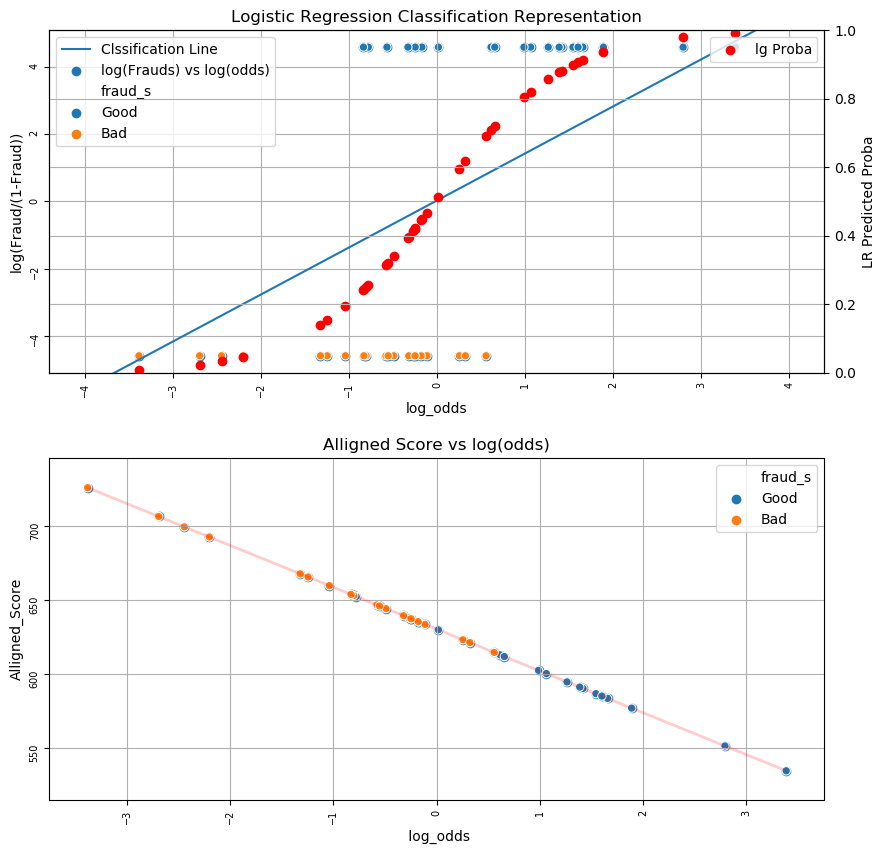

---------------------------------------------------------------------------
Example Dataframe is as follows :


,good_proba,bad_proba,fraud,fraud_s,odds,log_odds,Alligned_Score
0,0.839924,0.160076,1,Good,5.247050,1.657666,583.420359
1,0.314526,0.685474,1,Good,0.458845,-0.779042,652.350277
2,0.743554,0.256446,1,Good,2.899453,1.064522,600.199294
3,0.824163,0.175837,1,Good,4.687076,1.544809,586.612875
4,0.648955,0.351045,1,Good,1.848637,0.614449,612.931031
5,0.457358,0.542642,1,Good,0.842834,-0.170985,635.149470
6,0.438644,0.561356,1,Good,0.781401,-0.246667,637.290383
7,0.832371,0.167629,1,Good,4.965573,1.602529,584.980094
8,0.418378,0.581622,1,Good,0.719329,-0.329437,639.631792
9,0.361838,0.638162,1,Good,0.567000,-0.567396,646.363207


In [4]:
risk_score_example(20)

## Observations :
1. Logistic regression line classifies good and bad frauds.
2. Aligned score is linearly mapped for the log(odds).
3. Good transactions has lower risk scores than the bad transactions.
4. Score corresponding to 1 pct bad rate is 500. Odds are doubling for 20 risk points which is PDO value. eg. Odds 0.033 (row no. 38) corresoponds to risk score of 726 and its doubled odds 0.067 (row no. 34) corresponds to risk score of 706.
> <font size =  "4"> Note: In this example we have adjusted scaling term 1 and scaling term 2 in such a way that score corresponding to 1% bad rate and PDO observations are correctly followed. In the next section of scorecard development our objective is to get a required distribution and stability of risk scorecard by tuning the PDO, score corresponding to 1% bad rate, scaling term 1 and scaling term 2 which results in not following the PDO and score corresponding to 1% bad rate as observed here.</font>

# 2. Risk Scorecard development:
## Following section of this notebook can be used for interactive PDO calibration
### Inputs required for PDO calibration are:
<font size =  "3">
    
        1. train_score_dist = This is a train score dataframe generated from the model probabilites distribution (required columns=fraud, SCORE, count)
        2. test_score_dist = This is a test score dataframe generated from the model probabilites distribution (required columns=fraud, SCORE, count)
        3. oot_score_dist = This is a train score dataframe generated from the model probabilites distribution (required columns=fraud, SCORE, count)
        4. Intercept = intercept of logistic regression fit on train score values and fraud labels
        5. Slope = slope of logistic regression fit on train score values and fraud labels 
        6. Score corresponding to 1% bad rate : needs to be defined at PDO calibration
        7. PDO value : needs to be defined at PDO calibration
        8. Scaling term 1 : Scaling factor for the first term of aligned score equation. Needs to be defined at PDO calibration (default value = ln(100) = 4.605 )
        9. Scaling term 2 : Scaling factor for the second term of aligned score equation. Needs to be defined at PDO calibration (default value = 1)
</font>

### Outputs:
<font size =  "3">
    
        1. Risk scorecard 
        2. Following graphs:
            a. Percentage of total transactions in each score bucket
            b. Bad Rate and Flase Positives in each score bucket"
            c. Cummulative False Positive
</font>

#### Aligned score equation:
> <font size =  "4"> Developed aligned score equation which is linear function of log of odds.</font>
> <font color='yellow'> <font size =  "5"> $Aligned Score= \bigg[ Score Correponding To 1 Pct Bad Rate + \frac{ PDO}{ln(2)} * (Scaling Term 1 + intercept )\bigg] - \bigg[ \frac{ PDO}{ln(2)}*Slope*Scaling Term 2 * log(odds) \bigg]$ </font></font>

## Preparing required dataframe

In [49]:
def risk_score_example2(example_points,require_log_reg):
    """ 
    This function coputed the dataframe which will be used for scorecard development using PDO calibration. 
    Input: example_points - number of example points that you would like to use for this demo. Example points are good and bad points each.
    require_log_reg: True for tran data frame and False for rest datafeames
    """
    
    # lets prepare the dataframe of these example points
    np.random.seed(10)
    example_points_bad=int(example_points/10)
    good_proba=np.random.uniform(0.3,0.9,example_points)  # example points which belongs to good probability (Proba range = 0.3 to 1)
    good_proba=np.append(good_proba,np.random.uniform(0.1,0.7,example_points_bad)) # example points which belongs to bad probability (Proba range = 0 to 0.7)
    bad_proba=1-good_proba
    fraud_1=[1]*example_points # 1 - good example points (fraud label)
    fraud_0=[0]*example_points_bad # 0 - bad example points (fraud label)
    fraud=fraud_1+fraud_0
    fraud_1_s=["Good"]*example_points # 1 - good example points (fraud label)
    fraud_0_s=["Bad"]*example_points_bad # 0 - bad example points (fraud label)
    fraud_s=fraud_1_s+fraud_0_s
    
    
    ## --------------------      1.	Compute log of odds (log(good/bad)) of each transaction.   ---------------------- ##
    odds=good_proba/bad_proba
    log_odds=np.log(odds)
    
    data={"good_proba":good_proba,
         "bad_proba":bad_proba,
         "fraud":fraud,
          "fraud_s":fraud_s,
          "odds":odds,
         "log_odds":log_odds
         }
    example_score_df = pd.DataFrame(data)
    
    
    ## ------------------  2. Lets build a logistic regression model on log(odds), fraud labels  -------------------- ## 
    if require_log_reg==True:
        log_score = LogisticRegression(random_state=0, solver="lbfgs", max_iter = 1000).fit(pd.DataFrame(example_score_df['log_odds'])
                                , example_score_df['fraud'])
        print("-"*75)
        print("Logistic regressions Intercept and Slope are :")

         # Intercept value :
        print('Intercept:', log_score.intercept_.ravel())

        # Slope value :
        print('Slope:', log_score.coef_.ravel())
       
    print("-"*75)
    print("prepare dataframes to be used for PDO calibration")
    example_score_df['rw_num']=[i for i in range(example_score_df.shape[0])]
    example_score_df.rename(columns={'log_odds':'SCORE'},inplace=True)
    example_score_df=example_score_df.groupby(['fraud','SCORE'])['rw_num'].count().reset_index(name="count")
    print("Finished preparing the required dataframes for PDO calibration")
    print("-"*75)
    print("Shape of the dataframe is",example_score_df.shape)
    print("Columns of the dataframe is",example_score_df.columns)
    return(example_score_df)    

In [50]:
train_score_dist=risk_score_example2(200000,True) 

---------------------------------------------------------------------------
Logistic regressions Intercept and Slope are :
Intercept: [2.35134264]
Slope: [1.69368851]
---------------------------------------------------------------------------
prepare dataframes to be used for PDO calibration
Finished preparing the required dataframes for PDO calibration
---------------------------------------------------------------------------
Shape of the dataframe is (220000, 3)
Columns of the dataframe is Index(['fraud', 'SCORE', 'count'], dtype='object')


In [54]:
test_score_dist=risk_score_example2(100000,False) 

---------------------------------------------------------------------------
prepare dataframes to be used for PDO calibration
Finished preparing the required dataframes for PDO calibration
---------------------------------------------------------------------------
Shape of the dataframe is (110000, 3)
Columns of the dataframe is Index(['fraud', 'SCORE', 'count'], dtype='object')


In [55]:
oot_score_dist=risk_score_example2(50000,False) 

---------------------------------------------------------------------------
prepare dataframes to be used for PDO calibration
Finished preparing the required dataframes for PDO calibration
---------------------------------------------------------------------------
Shape of the dataframe is (55000, 3)
Columns of the dataframe is Index(['fraud', 'SCORE', 'count'], dtype='object')


## Defining the Functions

In [43]:
def PDO_cal_train(train_score_dist,Intercept,Slope,score_corresponding_to_1pct_bad_rate,PDO,Term_1_scaling_factor,Term_2_scaling_factor):
    """
    This function compares all the necessay metrics for score calibration and plots the graphs.
    
    Inputs:
        train_score_dist = This is a train score dataframe generated from the model probabilites distribution (columns=fraud, SCORE, count)
        Intercept = Intercept of logistic regression model built on train scores and frauds
        Slope  = Slope of logistic regression model built on train scores and frauds
        score_corresponding_to_1pct_bad_rate = score that you want to set for 1% bad rate
        PDO = PDO that you want to set for 1% bad rate
    
    Output:
        display calibration plots
        display metrics dataframe
        return train_score_alignment dataframe
    """
       
    Aligned_score_term1=score_corresponding_to_1pct_bad_rate+((Term_1_scaling_factor+Intercept)*PDO/math.log(2))
    Aligned_score_term2=PDO*Slope/math.log(2)*Term_2_scaling_factor
    
    print("-"*75)
    print("Aligned Score Equation is= %5.3f - %5.3f*score" %(Aligned_score_term1,Aligned_score_term2))
    print("-"*75)
    
    ## generating the scores and corresponding score range
    train_score_dist['Alligned_Score']=Aligned_score_term1-Aligned_score_term2*train_score_dist['SCORE']
    train_score_dist['Score_range_min']=np.floor((train_score_dist['Alligned_Score']-1)/20)*20
    train_score_dist.loc[train_score_dist["Score_range_min"] >980, "Score_range_min"] = 980
    train_score_dist.loc[train_score_dist["Score_range_min"] <300, "Score_range_min"] = 300
    train_score_dist['Score_range_max']=train_score_dist['Score_range_min']+19
    
    ## generating the risk metrics dataframe
    train_score_alignment=pd.DataFrame([i for i in range (980,280,-20)],columns =['Score_range_min'])
    train_score_alignment['Score_range_max']=train_score_alignment['Score_range_min']+19
    train_score_alignment['Score_range']=train_score_alignment['Score_range_min'].astype(str)+"-"+train_score_alignment['Score_range_max'].astype(str)
    train_score_alignment['Total_Txns_All'] = train_score_alignment['Score_range_min'].map(train_score_dist.groupby('Score_range_min')['count'].sum())
    train_score_alignment['KGB_Txns'] = train_score_alignment['Score_range_min'].map(train_score_dist.query("fraud == 0 | fraud == 1").groupby('Score_range_min')['count'].sum())
    train_score_alignment['Good_Txns'] = train_score_alignment['Score_range_min'].map(train_score_dist.query("fraud == 1 ").groupby('Score_range_min')['count'].sum())
    train_score_alignment['Bad_Txns'] = np.floor(train_score_alignment['Score_range_min'].map(train_score_dist.query("fraud == 0 ").groupby('Score_range_min')['count'].sum()))
    train_score_alignment['Indeterminate_Txns'] = train_score_alignment['Score_range_min'].map(train_score_dist.query("fraud == 2 ").groupby('Score_range_min')['count'].sum())
    train_score_alignment.replace(np.nan,0,inplace=True)
    train_score_alignment=train_score_alignment.astype({'Bad_Txns':int,'Indeterminate_Txns':int})
    train_score_alignment['Bad_Rate'] = np.round(train_score_alignment['Bad_Txns']/train_score_alignment['KGB_Txns']*100,2)
    train_score_alignment['Pct_Total_Txns'] = np.round(train_score_alignment['Total_Txns_All']/train_score_alignment['Total_Txns_All'].sum()*100,2)
    train_score_alignment['Pct_Total_Bad_Txns'] = np.round(train_score_alignment['Bad_Txns']/train_score_alignment['Bad_Txns'].sum()*100,2)
    train_score_alignment['Pct_Total_Good_Txns'] = np.round(train_score_alignment['Good_Txns']/train_score_alignment['Good_Txns'].sum()*100,2)
    train_score_alignment['Pct_Total_KGB_Txns'] = np.round(train_score_alignment['KGB_Txns']/train_score_alignment['KGB_Txns'].sum()*100,2)
    train_score_alignment['Cum_Pct_Total_Txns']=train_score_alignment['Pct_Total_Txns'].cumsum(axis=0)
    train_score_alignment['Cum_Pct_Total_Bad_Txns']=train_score_alignment['Pct_Total_Bad_Txns'].cumsum(axis=0)
    train_score_alignment['Cum_Pct_Total_Good_Txns']=train_score_alignment['Pct_Total_Good_Txns'].cumsum(axis=0)
    train_score_alignment['Cum_Pct_Total__KGB_Txns']=train_score_alignment['Pct_Total_KGB_Txns'].cumsum(axis=0)
    train_score_alignment['KS']=(train_score_alignment['Pct_Total_Bad_Txns']-train_score_alignment['Pct_Total_Good_Txns'])
    train_score_alignment['False_Positive']=np.round(train_score_alignment['Good_Txns']/train_score_alignment['Bad_Txns'],2)
    train_score_alignment['Cum_False_Positive']=np.round(train_score_alignment['Good_Txns'].cumsum(axis=0)/train_score_alignment['Bad_Txns'].cumsum(axis=0),2)
    train_score_alignment.drop(['Score_range_min','Score_range_max'],axis=1,inplace=True)
    
    ## Plot the required graphs
    fig = plt.figure(figsize=(13, 10))

    x = np.linspace(0., 5., 100)
    y = np.sin(x)

    plt.subplots_adjust(wspace= 0.25, hspace= 0.25)

    sub1 = fig.add_subplot(2,2,1) # two rows, two columns, fist cell
    sub1.plot(train_score_alignment['Score_range'],train_score_alignment['Pct_Total_Txns'])
    sub1.set_xlabel(" Score Range")
    sub1.set_ylabel("%")
    sub1.set_title("Percentage of total transactions in each score bucket")
    sub1.tick_params(labelrotation=90,labelsize = 7)
    sub1.set_ylim([0, train_score_alignment['Pct_Total_Txns'].max()+1])
    sub1.grid()

    # Create second axes, the top-left plot with orange plot
    sub2 = fig.add_subplot(2,2,2) # two rows, two columns, second cell
    sub2.plot(train_score_alignment['Score_range'],train_score_alignment['Bad_Rate'],label='Bad Rate')
    sub2.set_ylabel("%")
    sub2.set_xlabel("Score Range")
    sub2.set_title("Bad Rate and Flase Positives in each score bucket")
    sub2.tick_params(labelrotation=90,labelsize = 7)
    sub2.legend(loc='upper left')
    sub2.set_ylim([0, train_score_alignment['Bad_Rate'][train_score_alignment['Bad_Rate']!=np.inf].max()+1])
    sub2 = sub2.twinx()
    sub2.plot(train_score_alignment['Score_range'],train_score_alignment['False_Positive'],label='False Positive',color='r')
    sub2.set_ylim([0, train_score_alignment['False_Positive'][train_score_alignment['False_Positive']!=np.inf].max()+1])
    sub2.legend(loc='upper right')

    # Create third axes, a combination of third and fourth cell
    sub3 = fig.add_subplot(2,2,(3,4)) # two rows, two colums, combined third and fourth cell
    sub3.plot(train_score_alignment['Score_range'],train_score_alignment['Cum_False_Positive'])
    sub3.set_xlabel("Score Range")
    sub3.set_title("Cummulative False Positive")
    sub3.tick_params(labelrotation=90)
    sub3.grid()
    sub3.set_ylim([0, train_score_alignment['Cum_False_Positive'][train_score_alignment['Cum_False_Positive']!=np.inf].max()+1])

    plt.show()
    
    ## Display the risk metrics dataframe
    train_score_alignment.loc['total']= train_score_alignment.sum()
    train_score_alignment.loc[train_score_alignment.index[-1], ['Score_range','Bad_Rate','Cum_Pct_Total_Txns','Cum_Pct_Total_Bad_Txns','Cum_Pct_Total_Good_Txns','Cum_Pct_Total__KGB_Txns','KS','False_Positive','Cum_False_Positive']] = ''
    
    from IPython.display import display, HTML
    def highlight_cols(x):

        # copy df to new - original data is not changed
        df = x.copy()

        # select all values to yellow color
        df.loc[:, :] = 'background-color: yellow'
        
        # overwrite values grey color
        df[['Cum Pct Total Txns', 'Cum Pct Total Bad Txns']] = 'background-color: TURQUOISE'

        # return color df
        return df 
    
    # Renaming the columns so as to display column names as wrapped
    coloumn_name_dict={'Score_range':'Score range', 'Total_Txns_All':'Total Txns All', 'KGB_Txns':'KGB Txns', 'Good_Txns':'Good Txns', 'Bad_Txns':'Bad Txns',
       'Indeterminate_Txns':'Indeterminate Txns', 'Bad_Rate':'Bad Rate', 'Pct_Total_Txns':'Pct Total Txns',
       'Pct_Total_Bad_Txns':'Pct Total Bad Txns', 'Pct_Total_Good_Txns':'Pct Total Good Txns', 'Pct_Total_KGB_Txns':'Pct Total KGB Txns',
       'Cum_Pct_Total_Txns':'Cum Pct Total Txns', 'Cum_Pct_Total_Bad_Txns':'Cum Pct Total Bad Txns',
       'Cum_Pct_Total_Good_Txns':'Cum Pct Total Good Txns', 'Cum_Pct_Total__KGB_Txns':'Cum Pct Total KGB Txns', 'KS':'KS',
       'False_Positive':'False Positive', 'Cum_False_Positive':'Cum False Positive'}
    
    coloumn_name_dict2 = {y: x for x, y in coloumn_name_dict.items()}
    train_score_alignment.rename(columns = coloumn_name_dict, inplace=True)
    
    with pd.option_context('display.precision', 2,'display.float_format', '{:.2f}'.format):
        display(HTML(train_score_alignment.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])]).apply(highlight_cols, axis = None).set_properties(**{'border': '1.3px solid green',
                          'color': 'magenta'}).to_html()))
    
    # restoring the column names to the original to be refered in subsequent cases
    train_score_alignment.rename(columns = coloumn_name_dict2, inplace=True)
    train_score_alignment.drop(train_score_alignment.tail(1).index,inplace=True) # drop last n rows

    return train_score_alignment

In [44]:
def PDO_cal_df_prep(train_score_dist,Intercept,Slope,score_corresponding_to_1pct_bad_rate,PDO,Term_1_scaling_factor,Term_2_scaling_factor):
    """
    This function prepares the test, oot dataframes based on the train PDO calibration observations.
    
    Inputs:
        train_score_dist = This is a train score dataframe generated from the model probabilites distribution (columns=fraud, SCORE, count)
        Intercept = Intercept of logistic regression model built on train scores and frauds
        Slope  = Slope of logistic regression model built on train scores and frauds
        score_corresponding_to_1pct_bad_rate = score that you want to set for 1% bad rate
        PDO = PDO that you want to set for 1% bad rate
    
    Output:
        calibration plots
        metrics dataframe   
        return train_score_alignment dataframe
    """
    
    ## Aligned_score equation
    Aligned_score_term1=score_corresponding_to_1pct_bad_rate+((Term_1_scaling_factor+Intercept)*PDO/math.log(2))
    Aligned_score_term2=PDO*Slope/math.log(2)*Term_2_scaling_factor
    
    ## generating the scores and corresponding score range
    train_score_dist['Alligned_Score']=Aligned_score_term1-Aligned_score_term2*train_score_dist['SCORE']
    train_score_dist['Score_range_min']=np.floor((train_score_dist['Alligned_Score']-1)/20)*20
    train_score_dist.loc[train_score_dist["Score_range_min"] >980, "Score_range_min"] = 980
    train_score_dist.loc[train_score_dist["Score_range_min"] <300, "Score_range_min"] = 300
    train_score_dist['Score_range_max']=train_score_dist['Score_range_min']+19
    
    ## generating the risk metrics dataframe
    train_score_alignment=pd.DataFrame([i for i in range (980,280,-20)],columns =['Score_range_min'])
    train_score_alignment['Score_range_max']=train_score_alignment['Score_range_min']+19
    train_score_alignment['Score_range']=train_score_alignment['Score_range_min'].astype(str)+"-"+train_score_alignment['Score_range_max'].astype(str)
    train_score_alignment['Total_Txns_All'] = train_score_alignment['Score_range_min'].map(train_score_dist.groupby('Score_range_min')['count'].sum())
    train_score_alignment['KGB_Txns'] = train_score_alignment['Score_range_min'].map(train_score_dist.query("fraud == 0 | fraud == 1").groupby('Score_range_min')['count'].sum())
    train_score_alignment['Good_Txns'] = train_score_alignment['Score_range_min'].map(train_score_dist.query("fraud == 1 ").groupby('Score_range_min')['count'].sum())
    train_score_alignment['Bad_Txns'] = train_score_alignment['Score_range_min'].map(train_score_dist.query("fraud == 0 ").groupby('Score_range_min')['count'].sum())
    train_score_alignment['Indeterminate_Txns'] = train_score_alignment['Score_range_min'].map(train_score_dist.query("fraud == 2 ").groupby('Score_range_min')['count'].sum())
    train_score_alignment.replace(np.nan,0,inplace=True)
    train_score_alignment=train_score_alignment.astype({'Bad_Txns':int,'Indeterminate_Txns':int})
    train_score_alignment['Bad_Rate'] = np.round(train_score_alignment['Bad_Txns']/train_score_alignment['KGB_Txns']*100,2)
    train_score_alignment['Pct_Total_Txns'] = np.round(train_score_alignment['Total_Txns_All']/train_score_alignment['Total_Txns_All'].sum()*100,2)
    train_score_alignment['Pct_Total_Bad_Txns'] = np.round(train_score_alignment['Bad_Txns']/train_score_alignment['Bad_Txns'].sum()*100,2)
    train_score_alignment['Pct_Total_Good_Txns'] = np.round(train_score_alignment['Good_Txns']/train_score_alignment['Good_Txns'].sum()*100,2)
    train_score_alignment['Pct_Total_KGB_Txns'] = np.round(train_score_alignment['KGB_Txns']/train_score_alignment['KGB_Txns'].sum()*100,2)  
    train_score_alignment['Cum_Pct_Total_Txns']=train_score_alignment['Pct_Total_Txns'].cumsum(axis=0)
    train_score_alignment['Cum_Pct_Total_Bad_Txns']=train_score_alignment['Pct_Total_Bad_Txns'].cumsum(axis=0)
    train_score_alignment['Cum_Pct_Total_Good_Txns']=train_score_alignment['Pct_Total_Good_Txns'].cumsum(axis=0)
    train_score_alignment['Cum_Pct_Total__KGB_Txns']=train_score_alignment['Pct_Total_KGB_Txns'].cumsum(axis=0)
    train_score_alignment['KS']=(train_score_alignment['Pct_Total_Bad_Txns']-train_score_alignment['Pct_Total_Good_Txns'])
    train_score_alignment['False_Positive']=np.round(train_score_alignment['Good_Txns']/train_score_alignment['Bad_Txns'],2)
    train_score_alignment['Cum_False_Positive']=np.round(train_score_alignment['Good_Txns'].cumsum(axis=0)/train_score_alignment['Bad_Txns'].cumsum(axis=0),2)
    train_score_alignment.drop(['Score_range_min','Score_range_max'],axis=1,inplace=True)
    
    
    ## Display the risk metrics dataframe
    train_score_alignment.loc['total']= train_score_alignment.sum()
    train_score_alignment.loc[train_score_alignment.index[-1], ['Score_range','Bad_Rate','Cum_Pct_Total_Txns','Cum_Pct_Total_Bad_Txns','Cum_Pct_Total_Good_Txns','Cum_Pct_Total__KGB_Txns','KS','False_Positive','Cum_False_Positive']] = ''
    
    train_score_alignment.drop(train_score_alignment.tail(1).index,inplace=True) # drop last n rows
    
    return train_score_alignment

In [45]:
def PDO_cal_display(train_score_alignment,test_score_alignment,oot_score_alignment):
    """
    This function compares all the necessay metrics for score calibration and plots the graphs.
    
    Inputs:
        train_score_alignment dataframe
        test_score_alignment dataframe
        oot_score_alignment dataframe
    
    Output:
        display calibration plots
        display metrics dataframe
    """
    
    ## Plot the required graphs
    fig = plt.figure(figsize=(13, 11))

    x = np.linspace(0., 5., 100)
    y = np.sin(x)

    plt.subplots_adjust(wspace= 0.25, hspace= 0.25)

    sub1 = fig.add_subplot(2,1,1) # two rows, two columns, fist cell
    sub1.plot(train_score_alignment['Score_range'],train_score_alignment['Pct_Total_Txns'],label='Train',color='b')
    sub1.plot(test_score_alignment['Score_range'],test_score_alignment['Pct_Total_Txns'],label='Test',color='g')
    sub1.plot(oot_score_alignment['Score_range'],oot_score_alignment['Pct_Total_Txns'],label='OOT',color='r')
    sub1.set_xlabel(" Score Range")
    sub1.set_ylabel("%")
    sub1.set_title("Percentage of total transactions in each score bucket")
    sub1.tick_params(labelrotation=90,labelsize = 7)
    sub1.legend()
    sub1.grid()

    # Create second axes, the top-left plot with orange plot
    sub2 = fig.add_subplot(2,1,2) # two rows, two columns, second cell
    sub2.plot(train_score_alignment['Score_range'],train_score_alignment['Cum_False_Positive'],label='Train',color='b')
    sub2.plot(test_score_alignment['Score_range'],test_score_alignment['Cum_False_Positive'],label='Test',color='g')
    sub2.plot(oot_score_alignment['Score_range'],oot_score_alignment['Cum_False_Positive'],label='OOT',color='r')
    sub2.set_xlabel("Score Range")
    sub2.set_title("Cumulative False Positive Comparison")
    sub2.tick_params(labelrotation=90,labelsize = 7)
    sub2.legend()
    sub2.grid()

    plt.show()
    
    ## Display the risk metrics dataframe
    train_score_alignment.loc['total']= train_score_alignment.sum()
    train_score_alignment.loc[train_score_alignment.index[-1], ['Score_range','Bad_Rate','Cum_Pct_Total_Txns','Cum_Pct_Total_Bad_Txns','Cum_Pct_Total_Good_Txns','Cum_Pct_Total__KGB_Txns','KS','False_Positive','Cum_False_Positive']] = ''
    
    test_score_alignment.loc['total']= test_score_alignment.sum()
    test_score_alignment.loc[test_score_alignment.index[-1], ['Score_range','Bad_Rate','Cum_Pct_Total_Txns','Cum_Pct_Total_Bad_Txns','Cum_Pct_Total_Good_Txns','Cum_Pct_Total__KGB_Txns','KS','False_Positive','Cum_False_Positive']] = ''
    
    oot_score_alignment.loc['total']= oot_score_alignment.sum()
    oot_score_alignment.loc[oot_score_alignment.index[-1], ['Score_range','Bad_Rate','Cum_Pct_Total_Txns','Cum_Pct_Total_Bad_Txns','Cum_Pct_Total_Good_Txns','Cum_Pct_Total__KGB_Txns','KS','False_Positive','Cum_False_Positive']] = ''
    
    from IPython.display import display, HTML
    def highlight_cols(x):

        # copy df to new - original data is not changed
        df = x.copy()

        # select all values to yellow color
        df.loc[:, :] = 'background-color: yellow'
        
        # overwrite values grey color
        df[['Cum Pct Total Txns', 'Cum Pct Total Bad Txns']] = 'background-color: TURQUOISE'

        # return color df
        return df 
    
    # Renaming the columns so as to display column names as wrapped
    coloumn_name_dict={'Score_range':'Score range', 'Total_Txns_All':'Total Txns All', 'KGB_Txns':'KGB Txns', 'Good_Txns':'Good Txns', 'Bad_Txns':'Bad Txns',
       'Indeterminate_Txns':'Indeterminate Txns', 'Bad_Rate':'Bad Rate', 'Pct_Total_Txns':'Pct Total Txns',
       'Pct_Total_Bad_Txns':'Pct Total Bad Txns', 'Pct_Total_Good_Txns':'Pct Total Good Txns', 'Pct_Total_KGB_Txns':'Pct Total KGB Txns',
       'Cum_Pct_Total_Txns':'Cum Pct Total Txns', 'Cum_Pct_Total_Bad_Txns':'Cum Pct Total Bad Txns',
       'Cum_Pct_Total_Good_Txns':'Cum Pct Total Good Txns', 'Cum_Pct_Total__KGB_Txns':'Cum Pct Total KGB Txns', 'KS':'KS',
       'False_Positive':'False Positive', 'Cum_False_Positive':'Cum False Positive'}
    
    train_score_alignment.rename(columns =coloumn_name_dict, inplace=True)
    
    test_score_alignment.rename(columns =coloumn_name_dict, inplace=True)
    
    oot_score_alignment.rename(columns =coloumn_name_dict, inplace=True)    
    
    print("-"*50+" Train Dataframe " + "-"*50)
    print("-"*100)
    with pd.option_context('display.precision', 2,'display.float_format', '{:.2f}'.format):
        display(HTML(train_score_alignment.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])]).apply(highlight_cols, axis = None).set_properties(**{'border': '1.3px solid green',
                          'color': 'magenta'}).to_html()))
          
    print("-"*50+" Test Dataframe " + "-"*50)
    print("-"*100)
    with pd.option_context('display.precision', 2,'display.float_format', '{:.2f}'.format):
        display(HTML(test_score_alignment.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])]).apply(highlight_cols, axis = None).set_properties(**{'border': '1.3px solid green',
                          'color': 'magenta'}).to_html()))
          
    print("-"*50+" OOT Dataframe " + "-"*50)
    print("-"*100)
    with pd.option_context('display.precision', 2,'display.float_format', '{:.2f}'.format):
        display(HTML(oot_score_alignment.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])]).apply(highlight_cols, axis = None).set_properties(**{'border': '1.3px solid green',
                          'color': 'magenta'}).to_html()))

## Calibration GUI
### Calibration Objectives:
<font size =  "3">
    
Aim is to tune the values of score corresponding to 1% bad rate, PDO, scaling term 1 and Scaling term 2 :

        1. To get the well distribution of cummulative percentage of total transactions and cummulative percentage of bad transactions  throught the score range (300-999).
        2. Risk scorecard should be able to capture high cummulative percentage of bad transactions at lower cummulative percentage of total transactions.
        3. As the transaction data has much higher good transactions than the bad transactions, scorecard should be left skewed for cummulative percentage of total transactions on score range. (Score range from 999 -300)
        4. As developed model is already trained for bias variance tradeoff, scorecard shoould show similar distribution for train, test and oot data.
</font>

In [53]:
### Specify widgets

form = widgets.VBox()
# score corresponding to 1% bad rate
score_corresponding_to_1pct_bad_rate = BoundedFloatText(description="$$Score:$$", 
                             value=450, min=0.0, max=1000.0,
                             padding = 5)

# PDO Value
PDO = BoundedFloatText(description="$$PDO:$$", 
                             value=20, min=0.0, max=1000.0,
                             padding = 5)

# Term_1_scaling_factor Value (default value = ln(100) = 4.605 )
Term_1_scaling_factor = BoundedFloatText(description="$$Term 1:$$", 
                             value=4.605, min=-1000.0, max=1000.0,
                             # padding = 5
                                        )
# 2.23 , 2.32
# Term_2_scaling_factor Value (Default value = 1 )
Term_2_scaling_factor = BoundedFloatText(description="$$Term 2:$$", 
                             value=1, min=-1000.0, max=1000.0,
                             # padding = 5
                            )


# Intercept Value
Intercept = BoundedFloatText(description="$$Intercept:$$", 
                             value=2.08986081, min=-500, max=500,
                             padding = 5)

# Slope Value
Slope = BoundedFloatText(description="$$Slope:$$", 
                             value=3.63033797, min=-500, max=500,
                             padding = 5)

## Dropdown option to show only train or entire train test oot
dropdown_display =widgets.RadioButtons(options = ["Display only Train data","Display Train Test and OOT"],
                                                value="Display only Train data",
                                                description="Data Display Option")

button = widgets.Button(description="Click to Run Calibration",button_style='info')

form.children = [score_corresponding_to_1pct_bad_rate, PDO,Term_1_scaling_factor,Term_2_scaling_factor, Intercept, Slope, dropdown_display, button]

### captures the output to be displayedd
output_cal = widgets.Output()
## clear the output with every new entry
def pdo_calibration_eventhandler(change):
    output_cal.clear_output()
    with output_cal:
        print("-"*75)
        print("Score is score corresponding to 1% bad rate")
        print("PDO value is points to double the odds")
        print("Term 1 is a scaling term 1")
        print("Term 2 is a scaling term 2")
        print("Intercept is intercept of logistic regression fit on train score values and fraud labels")
        print("Slope is slope of logistic regression fit on train score values and fraud labels")
        print("Data display option allows to choose either train data or train test oot data")
        print("-"*75)
        train_score_alignment=PDO_cal_train(train_score_dist,Intercept.value,Slope.value,score_corresponding_to_1pct_bad_rate.value,PDO.value,Term_1_scaling_factor.value,Term_2_scaling_factor.value)
        
        if (dropdown_display.value == "Display Train Test and OOT"):
            ## test and oot dataframe preperation based on train calibration pdo values
            test_score_alignment=PDO_cal_df_prep(test_score_dist,Intercept.value,Slope.value,score_corresponding_to_1pct_bad_rate.value,PDO.value,Term_1_scaling_factor.value,Term_2_scaling_factor.value)
            oot_score_alignment=PDO_cal_df_prep(oot_score_dist,Intercept.value,Slope.value,score_corresponding_to_1pct_bad_rate.value,PDO.value,Term_1_scaling_factor.value,Term_2_scaling_factor.value)

            ## display all the results
            PDO_cal_display(train_score_alignment,test_score_alignment,oot_score_alignment)
        
        
## bind the handler function and widgests
button.on_click(pdo_calibration_eventhandler)   
output_cal.layout.width='1200px' ## adds the slider to the dataframe to scroll horrizontaly
display(form,output_cal)

Output(layout=Layout(width='1200px'))

## Observations
<font size =  "3">
    
        1. Obtained well distribution of cummulative percentage of total transactions and cummulative percentage of bad transactions throught the score range (300-999).
        2. Scorecard shows similar distribution for train, test and oot data.
        3. Tuned scaling for term 1 and scaling for term 2 along with score corresponding to 1% bad rate and PDO.
</font>

## References:


<font size =  "3">
    
[1] Siddiqi, N. (2012). Credit risk scorecards: developing and implementing intelligent credit scoring. John Wiley & Sons.

[2] [Credit Scoring — Scorecard Development Process by Sandy Liu](https://medium.com/@yanhuiliu104/credit-scoring-scorecard-development-process-8554c3492b2b)

[3] [What does "20/ln(2)" mean in logistic regression in relation to credit scoring model?](https://stats.stackexchange.com/questions/10092/what-does-20-ln2-mean-in-logistic-regression)
    
</font>